# _Experimentation: TBD_

**TL:DR** --> This notebook will be repurposed for creating v1 of the training pipeline. For the purposes of experimentation we'll be using data comprised of tweets from 03/20/2020 through 03/24/2020. 

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import libraries
import fundamentals
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import string
import os
import re
from tqdm.autonotebook import tqdm
tqdm.pandas()

/opt/conda/envs/fastai/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## _Load Data_

In [4]:
%%time
# strings of file paths and file name for data
origpath = "/notebooks/CovidDisinfo-Detect/experiments"
datapath = "/notebooks/CovidDisinfo-Detect/data/interim"
filename1 = "covid19_0320_0324.pkl"

# load data into pandas dataframe
df_0320_0324 = fundamentals.load_data(origpath, datapath, filename1)

CPU times: user 5.54 s, sys: 2.66 s, total: 8.2 s
Wall time: 8.2 s


In [5]:
df_0320_0324.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3364618 entries, 2020-03-24 23:59:59 to 2020-03-20 01:37:05
Data columns (total 19 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id                  int64 
 1   conversation_id     int64 
 2   user_id             int64 
 3   username            object
 4   name                object
 5   tweet               object
 6   mentions            object
 7   urls                object
 8   photos              object
 9   replies_count       int64 
 10  retweets_count      int64 
 11  likes_count         int64 
 12  hashtags            object
 13  link                object
 14  retweet             bool  
 15  quote_url           object
 16  video               int64 
 17  reply_to_userids    object
 18  reply_to_usernames  object
dtypes: bool(1), int64(7), object(11)
memory usage: 490.9+ MB


## _Initial Exploration with regex & `re`_

In [13]:
# search for newline characters
def newline_search(text):
    """
    Searches for newline characters in 
    """
    regex = re.compile(r"\n+", re.I)
    if regex.findall(text) == []:
        return False
    else:
        return True
    
def newline_sub(text):
    """
    Removes newline characters from text.
    """
    regex = re.compile(r"\n+", re.I)
    if regex.findall(text) == []:
        return text
    else:
        return regex.sub(r" ", text)

In [14]:
# create a new column without the newline characters
df["clean_tweet"] = df["tweet"].progress_apply(newline_sub)

In [15]:
# check to make sure our cleaning worked
df["clean_tweet"].apply(newline_search).value_counts(dropna=False)

False    2624891
Name: clean_tweet, dtype: int64

## `5G_search`

In [55]:
text = """
Did you know that 5G 5g 5 g & telephone network phone signals signal and its radiation caused covid19? it hasn't been debunked yet!
"""

In [56]:
# ((not)?[\s]?debunked) --> searches for not debunked, with not as optional subgroup

def fiveg_search(text):
    """
    Searches for 5G-related conspiracy theory terms in a given text.
    """
    regex = re.compile(r"(5[\s]?G)+|(network)+|((tele)?phone)+|(signal(s)?)+|(radiation)+", re.I)
    return ",".join([x.group() for x in regex.finditer(text)])

In [59]:
%%timeit
fiveg_search(text)

27.4 µs ± 604 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [58]:
# create a column so we can examine what the regex search turns up
df["fiveg_search"] = df["clean_tweet"].progress_apply(fiveg_search)

In [61]:
# what do the results look like? 
df["fiveg_search"].value_counts()[:26]

                     2590158
phone                  10649
network                 8670
5G                      2875
5g                      2701
Network                 2012
Phone                   1039
telephone                974
phone,phone              932
signal                   828
network,network          400
Network,network          311
signals                  298
5 G                      294
Signal                   226
Phone,phone              202
5 g                      202
radiation                179
PHONE                    150
Telephone                149
5G,5G                    132
phone,phone,phone         82
5G,5g                     74
NETWORK                   72
Network,Network           62
network,Network           56
Name: fiveg_search, dtype: int64

In [92]:
# create subset dataframe containing 5g instances
df_fiveg = df[df["fiveg_search"].str.contains(r"(5[\s]?G)+")]

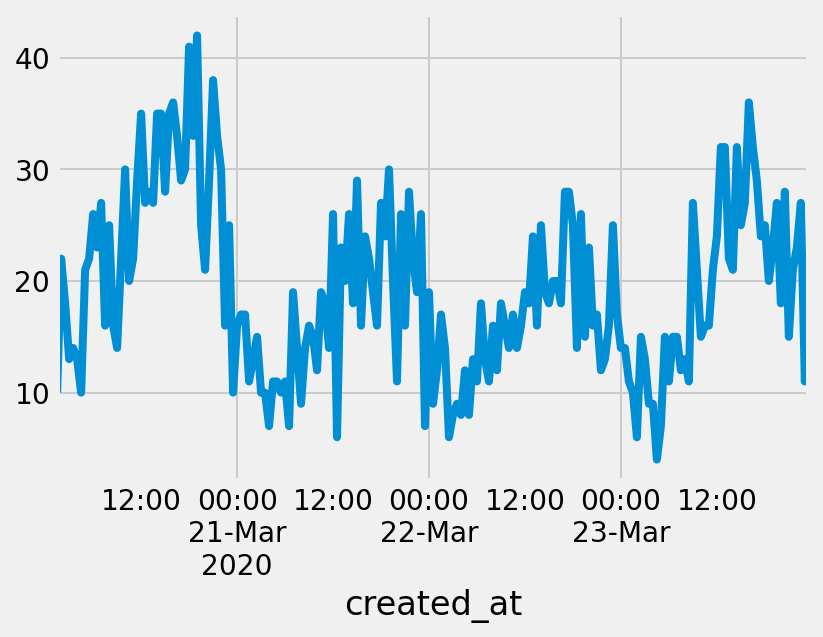

In [97]:
df_fiveg.resample("30min")["id"].count().plot()

In [105]:
for n in range(20):
    print(df_fiveg["clean_tweet"].sample(n=1, random_state=n).iloc[0] + "\n")

Hospital Administrators: US Physicians/Healthcare Workers For Personal Protective Equipment in COVID-19 Pandemic ( DO NOT DONATE!) - Sign the Petition!  http://chng.it/HZ5Gn9g2  via @Change

The reaction to the figure of 59k  was the same as mine. The graphics provided by Reuters relating to Patient 31 in South Korea (along with the rising daily death toll in Italy) was what led me to change my thinking about just how virulent Covid-19 is:  https://graphics.reuters.com/CHINA-HEALTH-SOUTHKOREA-CLUSTERS/0100B5G33SB/index.html …

COVID-19  pic.twitter.com/fDdj8WM5G4

Listen to GIE Senior Associate Editor, Dr. Douglas Adler, talk with Dr. Alessandro Repici about his experience with the COVID-19 outbreak in Milan, Italy.  http://ow.ly/mtBj50yRxw6  pic.twitter.com/p5Gx56xv6N

COVID-19: Gani Adams postpones Oke’badan, Eledumare festivals indefinitely  https://newsverge.com/2020/03/22/covid-19-gani-adams-postpones-okebadan-eledumare-festivals-indefinitely/ … pic.twitter.com/5GDelRD4FX

Find ou

In [85]:
def test_5g(text):
    regex = re.compile(r"(5[\s]?G)+|(cause[s]?)+", re.I)
    return ",".join([x.group() for x in regex.finditer(text)])

In [86]:
text = "What if 5G 5gcauses covid19 covid-19 covid 19?"

In [87]:
test_5g(text)

'5G,5g,causes'

In [88]:
df["clean_tweet"].progress_apply(test_5g).value_counts()[:25]

                           2516604
cause                        88869
cause,cause                   5734
causes                        3644
5G                            2865
5g                            2664
Cause                         1174
CAUSE                          803
cause,cause,cause              295
5 G                            287
cause,causes                   245
5 g                            184
causes,causes                  180
causes,cause                   155
Cause,cause                    135
5G,5G                          131
Causes                          93
cause,5G                        71
5G,5g                           65
cause,5g                        56
5G,cause                        54
Causes,causes                   33
cause,cause,cause,cause         29
cause,CAUSE                     29
cause,Cause                     29
Name: clean_tweet, dtype: int64